In [1]:
# import sys
# !{sys.executable} -m pip install praw

In [2]:
# import sys
# !{sys.executable} -m pip install pymongo

In [3]:
import praw
import pandas as pd
import requests
import json
import numpy as np

## didn't use praw 1000 posts limit

In [5]:
# rdt = praw.Reddit(client_id='HIHlsSpijlrRNg', client_secret='2AHipnMKSKyO7vNj4TLoZUrgrQk', user_agent='Dataorg')

In [6]:
# ind = rdt.subreddit('India').top(limit=1500)
# lis = {}
# for post in ind:
#     if post.link_flair_text not in lis.keys():
#         lis[post.link_flair_text] = 1
#     else:
#         lis[post.link_flair_text]+=1
# sum(lis.values())


## Collecting pots using pushsift.io

In [7]:
# function for collecting some specific values from the data we get from the function below this function
#like tile and other stuff
def collectdata(subm, title, flair,author, created, submiid, cmntcount, selftxt, linkflaircolor):
    title.append(subm['title'])
    try: 
        flair.append(subm['link_flair_text'])
    except KeyError:
        flair.append("NaN" )  
    try:
        selftxt.append(subm['selftext'])
    except KeyError:
        selftxt.append("Nan")  
    try: 
        linkflaircolor.append(subm['link_flair_text_color'])
    except KeyError:
        linkflaircolor.append("Nan")
    author.append(subm["author"])
    submiid.append(subm['id'])
    cmntcount.append(subm['num_comments'])
    created.append(pd.to_datetime(subm['created_utc'], unit ='s'))
    

#function to collect the desired amount of data from a subreddit
def getsubreddata( after, subred):
    url = 'https://api.pushshift.io/reddit/search/submission/?&size=1000&after='+str(after)+'&subreddit='+str(subred)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']


title = []
flair = []
author = []
created = []
submiid = []
cmntcount = []
selftxt = []
linkflaircolor = []

after = int((pd.Timestamp(2019, 8, 1)- pd.Timestamp(1970,1,1))// pd.Timedelta('1s'))
subred = 'India'
bod = []
dataset = getsubreddata(after, subred)

while len(dataset) > 0:
    for submission in dataset:
        collectdata(submission, title, flair,author, created, submiid, cmntcount, selftxt, linkflaircolor)
    dataset = getsubreddata(subred=subred, after=dataset[-1]['created_utc'])
    

In [8]:
datadic= {'Title' : pd.Series(np.array(title), name = 'Title').astype(str),
    'Flair' : pd.Series(np.array(flair), name='Flair').astype(str),
    'Author' : pd.Series(np.array(author), name ='Author').astype(str),
    'Created' : pd.Series(np.array(created), name='Created').astype(np.datetime64) ,
    'id' : pd.Series(np.array(submiid), name='id').astype(str),
    'CmntCount' : pd.Series(np.array(cmntcount), name= 'CmntCount').astype(int),
    'text' : pd.Series(np.array(selftxt), name='text').astype(str),
    'falir color' : pd.Series(np.array(linkflaircolor), name='color').astype(str)
    }


In [49]:
df = pd.DataFrame(datadic)


## Flair count

In [50]:
dic = {}
for fal in flair:
    if fal not in dic.keys():
        dic[fal] = 1
    else:
        dic[fal]+=1
dic

{'Non-Political': 2161,
 'NaN': 9838,
 'Politics': 2122,
 'Science/Technology': 479,
 'AskIndia': 1385,
 'Photography': 254,
 'All CAPS.': 66,
 'Policy/Economy': 478,
 'Business/Finance': 726,
 '[R]eddiquette': 1507,
 'Sports': 138,
 'Food': 147,
 'Demonetization': 80,
 'Scheduled': 28,
 '| Low-effort Self Post |': 2,
 '| Image Rule Violation |': 1,
 'Low-effort self-post.': 38,
 '| Not Original/Relevant Title |': 1,
 '| Personal/Unverified Social Media |': 1,
 'Post link Directly': 1,
 '| Unverified Content / Disreputed Source |': 5,
 '| Self-promotion | | Low-effort Self Post |': 1,
 'Low Quality/Non OC Meme': 3,
 '| Not specific to India |': 2,
 '| Self-promotion |': 1}

## Inserting the flair count of each flar in each row

In [51]:
flairCount = np.nan
df['Flaircount'] = flairCount
# for key in dic.keys():
#     df[df.Flair==key].Flaircount=dic[key]
for key in dic.keys():
    df.loc[df[df.Flair == key].Flaircount.index, 'Flaircount']  = dic[key]


## removing all rows with flaircount<10 as they won't help

In [52]:
df.drop(df[df.Flaircount <10].index, axis = 0, inplace = True)

# removing some nan flair as theri size is too big

In [53]:
df[df.Flair == 'NaN'].index[1:19464:2]

Int64Index([    2,     4,     6,     9,    13,    15,    17,    20,    22,
               24,
            ...
            19412, 19422, 19434, 19436, 19441, 19443, 19448, 19454, 19459,
            19464],
           dtype='int64', length=4919)

In [54]:
df.drop(df[df.Flair == 'NaN'].index[1:19464:2], axis = 0, inplace=True)


In [55]:
df.drop(df[df.Flair == 'NaN'].index[1:19460:2], axis = 0, inplace = True)

# Cleaning Complete

In [59]:
df = df.reset_index()

In [64]:
df.drop(columns='index', inplace = True)

In [72]:
df.loc[df[df.Flair == 'NaN'].Flaircount.index, 'Flaircount'] = df[df.Flair == 'NaN'].shape[0]

In [73]:
df.head()

,Title,Flair,Author,Created,id,CmntCount,text,falir color,Flaircount
0,"Indians Road Rage in Brampton, Canada",Non-Political,qazwsx2121,2019-08-01 00:00:15,ckgl4m,16,,dark,2161.0
1,Sarana De Ki Marana De Maa Superhit Odia Bhaja...,NaN,GadgetsHomeUSA,2019-08-01 00:11:59,ckgpsj,0,,dark,2460.0
2,Cricket: The Ball Factory Arming Swing King An...,NaN,modi-modi-modi,2019-08-01 00:51:35,ckh655,0,,dark,2460.0
3,He said it right. Heard that there were plans ...,Non-Political,eddygta17,2019-08-01 01:19:32,ckhhu1,10,,dark,2161.0
4,Resident doctors on 24-hour nationwide strike ...,NaN,indilivenews,2019-08-01 02:03:47,ckhzlt,0,,dark,2460.0


In [85]:
# df.groupby(['Flair', 'Author']).Flaircount.sum()

## Comments collection(will take too much time) only 268 suid extracted in 15 mins with a dataset of size 12000

In [148]:
# def getcmntsdata(idt):
#     r = requests.get('https://api.pushshift.io/reddit/submission/comment_ids/{}'.format(idt))
#     data = json.loads(r.text)
#     lin = ",".join(data['data'])
#     if len(lin) > 0:
#         s = requests.get('https://api.pushshift.io/reddit/comment/search?ids={}'.format(lin)) 
#         cmn = json.loads(s.text)
#         return cmn['data']
#     return []


# def getcmnts(base):
#     allcm = []
#     for cm in base:
#         allcm.append(cm["body"])
#     return allcm


# cmnts = []
# for idt in df.id[0:500]:  
#     base = getcmntsdata(idt)
#     cmntlis = getcmnts(base)
#     cmnts.append(cmntlis)

# cmnts

In [149]:
rdt = praw.Reddit(client_id='HIHlsSpijlrRNg', client_secret='2AHipnMKSKyO7vNj4TLoZUrgrQk', user_agent='Dataorg')

In [1]:
cmnts = []
for idt in df.id:
    submission = rdt.submission(id=idt)
    submission.comments.replace_more(limit=0)
    cmntlis = []
    for top_level_comment in submission.comments:
        cmntlis.append(top_level_comment.body)
    cmnts.append(cmntlis)
cmnts

##  savings comments to mangodb

In [161]:
commentsmango = col.insert_one({'data':pickle.dumps(cmnts), 'name':'cmntstat', 'created_time': time.time()})

# new df

# Splitting data set for train test

## new test train as with comments as cmnts took too long to collect

In [274]:
df.Flair = df.Flair.replace(to_replace ='NaN', value = 'noFlair')

## Join comments

In [333]:
cmnts = df.Cmnts

In [336]:
cmnts = list(cmnts)

In [351]:
cmnts1 = list(map(lambda c : " ".join(c), cmnts))

In [352]:
cmnss = pd.Series(cmnts1)

In [357]:
#cmnss

In [354]:
df.drop(columns = 'Cmnts', inplace=True)

In [355]:
df['Cmnts'] = cmnss

In [356]:
df

,Title,Flair,Author,Created,id,CmntCount,text,falir color,Flaircount,Cmnts
0,indians road rage brampton canada,Non-Political,qazwsx2121,2019-08-01 00:00:15,ckgl4m,16,,dark,2161.0,Toronto is a cesspool.\n\nBetween fresh off th...
1,sarana de ki marana de maa superhit odia bhaja...,noFlair,GadgetsHomeUSA,2019-08-01 00:11:59,ckgpsj,0,,dark,2460.0,
2,cricket ball factory arming swing king anderso...,noFlair,modi-modi-modi,2019-08-01 00:51:35,ckh655,0,,dark,2460.0,
3,said right heard plans optional nonsubsidy tic...,Non-Political,eddygta17,2019-08-01 01:19:32,ckhhu1,10,,dark,2161.0,"There is something romantic about the word ""su..."
4,resident doctors 24hour nationwide strike nati...,noFlair,indilivenews,2019-08-01 02:03:47,ckhzlt,0,,dark,2460.0,
5,telugu christian medley 3 andhra kristhava kee...,Politics,GadgetsHomeUSA,2019-08-01 02:06:26,cki0ph,0,,dark,2122.0,
6,extending golden hour drdos new combat drugs r...,Science/Technology,pranjayv,2019-08-01 02:13:06,cki3hi,0,,light,479.0,
7,p karim benzema hattrick real madrid beat fene...,noFlair,ssingh5,2019-08-01 02:19:42,cki61g,0,,dark,2460.0,
8,watch womans soulful rendition lata mangeshkar...,Non-Political,chileboygreen,2019-08-01 02:23:55,cki7rl,0,,dark,2161.0,
9,1 teri hai jami kavyagan std 8 hindi sem 1,noFlair,GadgetsHomeUSA,2019-08-01 02:36:02,ckicka,0,,dark,2460.0,


In [88]:
from sklearn.model_selection import train_test_split

In [276]:
# Colums that will help in prediction of flair so flair has bee dropped
X  = df.loc[:, ['Title',  'Author', 'Created', 'id', 'CmntCount', 'text',   
       'falir color', 'Flaircount']]
# as flair column has to br predicted a seperate df fpr it
y = df.loc[:, 'Flair']

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.33, random_state=42)

## Saving the data in a Mangodb

In [278]:
import pickle
import time

In [279]:
from pymongo import MongoClient 
client = MongoClient("mongodb://localhost:27017/")

In [280]:
mydb = client['Test_train'] 
col = mydb['Tb'] 

In [281]:
traintest = col.insert_one({'data':pickle.dumps([X_train, X_test, y_train, y_test]), 'name': 'trainTestList', 'created_time':time.time()})

## Extracting data from Mongo 

In [132]:
data = col.find({'name': 'trainTestList'})

In [133]:
for i in data:
        json_data = i
#fetching model from db
pickled_model = json_data['trainTestList']
data = pickle.loads(pickled_model)


In [131]:
data[0]

array([['Suggestions to counter right wing brigading in this sub ?',
        'Thekikat', Timestamp('2019-08-11 02:56:03'), ..., '[removed]',
        'dark', 2122.0],
       ['Opinion | India must stop weaponizing the pain of Kashmiri Pandits [WASHINGTON POST]',
        'koukouki', Timestamp('2019-08-28 10:59:09'), ..., '', 'dark',
        1507.0],
       ["Faye D'Souza Resigns as Executive Editor From Mirror Now",
        'silentalways', Timestamp('2019-09-09 16:42:29'), ..., '',
        'dark', 1507.0],
       ...,
       ['"Nirvana" (4000x6000 | Hussain Sagar, Hyderabad)',
        'spacehentai', Timestamp('2019-08-19 06:33:14'), ..., '',
        'light', 254.0],
       ['Do teachings of Osho indirectly create suicidal tendencies amongst a person?',
        'deepmysteryindia', Timestamp('2019-08-04 00:10:40'), ...,
        '[removed]', 'light', 1385.0],
       ["I don't know what to say.", 'swatilekha14',
        Timestamp('2019-08-26 05:49:42'), ..., '', 'dark', 478.0]],
      dtype=

# Performing Classification

In [192]:
import matplotlib.pyplot as plt
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kesha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


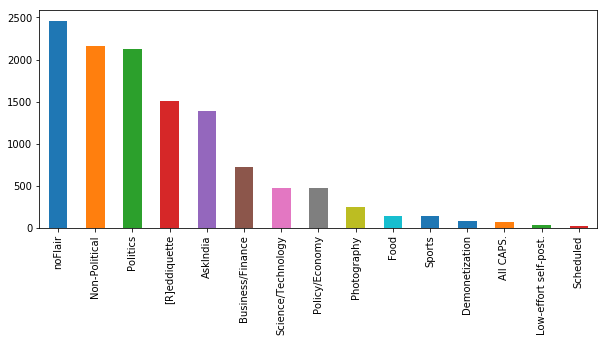

In [282]:
plt.figure(figsize=(10,4))
df.Flair.value_counts().plot(kind='bar')


In [283]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [284]:
def column_cleanup(text):
    if type(text) == np.nan:
        return np.nan
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

df['Title'] = df['Title'].apply(column_cleanup)

### Creating models

In [305]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [422]:
x = df.Title
Y = df.Flair
Encoder_Y = LabelEncoder()
Y = Encoder_Y.fit_transform(Y)
x_train, x_test, Y_train, Y_test = train_test_split(x.values, Y, test_size=0.33, random_state=42)

## Naive bayes with title

In [423]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
              ])


count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(x_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, Y_train)

from sklearn.metrics import classification_report
Y_pred = clf.predict(count_vect.transform(x_test))

print('accuracy %s' % accuracy_score(Y_pred, Y_test))
print(classification_report(Y_test, Y_pred, target_names=list(set(df_t.Flair))))

accuracy 0.383881496359528
                    precision    recall  f1-score   support

          Politics       0.00      0.00      0.00        22
              Food       0.43      0.33      0.37       476
         Scheduled       0.83      0.53      0.65       240
     [R]eddiquette       0.00      0.00      0.00        19
    Policy/Economy       1.00      0.07      0.14        41
       Photography       0.00      0.00      0.00        19
  Business/Finance       0.34      0.41      0.37       713
            Sports       1.00      0.03      0.06        68
     Non-Political       0.54      0.09      0.15       156
Science/Technology       0.45      0.71      0.55       715
          AskIndia       0.00      0.00      0.00         9

       avg / total       0.42      0.38      0.36      3983



C:\Users\kesha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 15, does not match size of target_names, 11
  .format(len(labels), len(target_names))
C:\Users\kesha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Naive Bayes with Comments

## Creating a new df wher cmnts is not empty

In [361]:
df_t = df[df.Cmnts != '']

## Removing useless flairs to imporve detection

In [396]:
# df_t = df_t[df_t.Flair != "noFlair"]
# df_t = df_t[df_t.Flair != "Demonetization"]
# df_t = df_t[df_t.Flair != "low self esteem posts"]
#df_t = df_t[df_t.Flair != "All CAPS."]

In [429]:
df_t

,Title,Flair,Author,Created,id,CmntCount,text,falir color,Flaircount,Cmnts,feature_combine
0,indians road rage brampton canada,Non-Political,qazwsx2121,2019-08-01 00:00:15,ckgl4m,16,,dark,2161.0,toronto cesspoolbetween fresh boat indian chin...,indians road rage brampton canadatoronto cessp...
3,said right heard plans optional nonsubsidy tic...,Non-Political,eddygta17,2019-08-01 01:19:32,ckhhu1,10,,dark,2161.0,something romantic word subsidy people love ge...,said right heard plans optional nonsubsidy tic...
11,indian social media made indians,AskIndia,divyaaaaaaaaaam,2019-08-01 03:00:08,ckim2e,20,I really wanna get off these American sites an...,light,1385.0,joke call indian social media user also singsa...,indian social media made indiansjoke call indi...
12,sexual assaults women increasing see women sis...,AskIndia,CeleritasLucis,2019-08-01 03:04:38,ckinsv,192,Many make the argument that women are sacred i...,light,1385.0,respect women show even ounce sexuality asexua...,sexual assaults women increasing see women sis...
18,really like,Non-Political,zavod311,2019-08-01 03:32:58,ckiyl1,6,,dark,2161.0,food religion religionive always dismissed zom...,really likefood religion religionive always di...
19,mamata banerjee minus mercurial prashant kisho...,Politics,GlobalCitizen12345,2019-08-01 03:38:00,ckj0d9,9,,dark,2122.0,prashant kumar many like political touts servi...,mamata banerjee minus mercurial prashant kisho...
20,lynchings open bigotry hindutva high seem far ...,Politics,Thekikat,2019-08-01 03:39:29,ckj0x2,2,,dark,2122.0,mad max bad bhakts,lynchings open bigotry hindutva high seem far ...
22,beyond borders priya live piston song written ...,Non-Political,throw_me_im_garbage,2019-08-01 03:44:34,ckj2tb,2,,dark,2161.0,shes awesome singer songwriter deserves attent...,beyond borders priya live piston song written ...
26,minors trapped spas sex trade kolkata,Non-Political,ppatra,2019-08-01 03:49:35,ckj4mj,10,,dark,2161.0,fun fact everybody knows bad grammar minors tr...,minors trapped spas sex trade kolkatafun fact ...
29,motor vehicles bill 2019 full list fines youll...,Policy/Economy,pramodc84,2019-08-01 03:58:20,ckj7pi,46,,dark,478.0,rules given below1 penalties range 1 000 2 000...,motor vehicles bill 2019 full list fines youll...


In [365]:
df_t['Cmnts'] = df_t['Cmnts'].apply(column_cleanup)

C:\Users\kesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [448]:
# Colums that will help in prediction of flair so flair has bee dropped
X  = df_t.loc[:, ['Title',  'Author', 'Created', 'id', 'CmntCount', 'text',   
       'falir color', 'Flaircount', 'Cmnts']]
# as flair column has to br predicted a seperate df fpr it
y = df_t.loc[:, 'Flair']

In [439]:
x = df_t.Cmnts
Y = df_t.Flair
Encoder_Y = LabelEncoder()
Y = Encoder_Y.fit_transform(Y)
x_train, x_test, Y_train, Y_test = train_test_split(x.values, Y, test_size=0.33, random_state=42)

In [431]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
              ])


count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(x_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, Y_train)

from sklearn.metrics import classification_report
Y_pred = clf.predict(count_vect.transform(x_test))

print('accuracy %s' % accuracy_score(Y_pred, Y_test))
print(classification_report(Y_test, Y_pred, target_names=list(set(df.Flair))))

accuracy 0.39601921757035
                       precision    recall  f1-score   support

             Politics       0.42      0.68      0.52       277
                 Food       0.00      0.00      0.00        49
            Scheduled       0.00      0.00      0.00        17
        [R]eddiquette       0.39      0.18      0.25       299
          Photography       0.00      0.00      0.00        27
       Policy/Economy       0.00      0.00      0.00        74
     Business/Finance       0.40      0.87      0.54       365
               Sports       0.00      0.00      0.00         8
        Non-Political       0.00      0.00      0.00        51
Low-effort self-post.       0.00      0.00      0.00        11
            All CAPS.       0.25      0.06      0.10       279

          avg / total       0.31      0.40      0.31      1457



C:\Users\kesha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 11, does not match size of target_names, 15
  .format(len(labels), len(target_names))
C:\Users\kesha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Naive Bayees Mixed

In [408]:
combine = df_t["Title"] + df_t["Cmnts"]+df_t['falir color']
df_t = df_t.assign(feature_combine = combine)

In [445]:
x = df_t.feature_combine
Y = df_t.Flair
Encoder_Y = LabelEncoder()
Y = Encoder_Y.fit_transform(Y)
x_train, x_test, Y_train, Y_test = train_test_split(x.values, Y, test_size=0.33, random_state=42)

In [433]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
              ])


count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(x_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, Y_train)

from sklearn.metrics import classification_report
Y_pred = clf.predict(count_vect.transform(x_test))

print('accuracy %s' % accuracy_score(Y_pred, Y_test))
print(classification_report(Y_test, Y_pred, target_names=list(set(df_t.Flair))))

accuracy 0.4186684969114619
                    precision    recall  f1-score   support

          Politics       0.43      0.73      0.54       277
              Food       0.00      0.00      0.00        49
         Scheduled       0.00      0.00      0.00        17
     [R]eddiquette       0.39      0.19      0.26       299
    Policy/Economy       0.00      0.00      0.00        27
       Photography       0.00      0.00      0.00        74
  Business/Finance       0.44      0.91      0.59       365
            Sports       0.00      0.00      0.00         8
     Non-Political       0.00      0.00      0.00        51
Science/Technology       0.00      0.00      0.00        11
          AskIndia       0.24      0.07      0.11       279

       avg / total       0.32      0.42      0.32      1457



C:\Users\kesha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Linear support vector machine

In [447]:
from sklearn.linear_model import SGDClassifier


LSVM_clf =SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(X_train_tfidf, Y_train)

Y_pred = clf.predict(count_vect.transform(x_test))

print('accuracy %s' % accuracy_score(Y_pred, Y_test))
print(classification_report(Y_test, Y_pred,target_names=list(set(df_t.Flair))))

accuracy 0.4186684969114619
                    precision    recall  f1-score   support

          Politics       0.43      0.73      0.54       277
              Food       0.00      0.00      0.00        49
         Scheduled       0.00      0.00      0.00        17
     [R]eddiquette       0.39      0.19      0.26       299
    Policy/Economy       0.00      0.00      0.00        27
       Photography       0.00      0.00      0.00        74
  Business/Finance       0.44      0.91      0.59       365
            Sports       0.00      0.00      0.00         8
     Non-Political       0.00      0.00      0.00        51
Science/Technology       0.00      0.00      0.00        11
          AskIndia       0.24      0.07      0.11       279

       avg / total       0.32      0.42      0.32      1457



C:\Users\kesha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [421]:
pickle.dump(LSVM_clf, open("model.pkl","wb"))

In [405]:
dic = {}
for fal in df_t.Flair:
    if fal not in dic.keys():
        dic[fal] = 1
    else:
        dic[fal]+=1
dic

{'Non-Political': 946,
 'AskIndia': 839,
 'Politics': 1105,
 'Policy/Economy': 239,
 'Business/Finance': 115,
 'Photography': 83,
 'Science/Technology': 153,
 '[R]eddiquette': 826,
 'Food': 50,
 'Sports': 39,
 'Scheduled': 20}

In [450]:
col.insert_one({'data':pickle.dumps([X, y]), 'name': 'X&y', 'created_time':time.time()})

# Data Collection method of no use to restricrted flairs(foudn throught reddit)

In [413]:
#flairs = ["AskIndia", "Non-Political", "[R]eddiquette", "Scheduled", "Photography", "Science/Technology", "Politics", "Business/Finance", "Policy/Economy", "Sports", "Food", "AMA"]

In [414]:
# subreddit = rdt.subreddit('india')
# topics_dict = {"flair":[], "title":[], "score":[], "id":[], "url":[], "comms_num": [], "created": [], "body":[], "author":[], "comments":[]}

# for flair in flairs:
  
#   get_subreddits = subreddit.search(flair, limit=100)
  
#   for submission in get_subreddits:
    
#     topics_dict["flair"].append(flair)
#     topics_dict["title"].append(submission.title)
#     topics_dict["score"].append(submission.score)
#     topics_dict["id"].append(submission.id)
#     topics_dict["url"].append(submission.url)
#     topics_dict["comms_num"].append(submission.num_comments)
#     topics_dict["created"].append(submission.created)
#     topics_dict["body"].append(submission.selftext)
#     topics_dict["author"].append(submission.author)
    
#     submission.comments.replace_more(limit=None)
#     comment = ''
#     for top_level_comment in submission.comments:
#       comment = comment + ' ' + top_level_comment.body
#     topics_dict["comments"].append(comment)
    
# topics_data = pd.DataFrame(topics_dict)


NameError: name 'get_date' is not defined

In [415]:
# topics_data

,flair,title,score,id,url,comms_num,created,body,author,comments
0,AskIndia,Need feedback for Insurance Policy that I took...,1,1s57oi,https://www.reddit.com/r/india/comments/1s57oi...,1,1.386254e+09,**Re-posting here because of lack of activity ...,dhavalcoholic,"Dear Policy Holder(Dhavalcoholic),\n \nWe req..."
1,AskIndia,Somebody want to kill my full family what to do?,94,b7pvwt,https://www.reddit.com/r/india/comments/b7pvwt...,24,1.554080e+09,"It's now 24hrs, But local police station is no...",amitkumarthakur,"Calm down.\nGo to the SP office of your town,..."
2,AskIndia,Ambassador of India takes back my newly issued...,13,bdfid1,https://www.reddit.com/r/india/comments/bdfid1...,27,1.555361e+09,"Hello /AskIndia! First time poster, long time...",FrustratedOCIHopeful,"Honestly, she and her supervisor behaved *exa..."
3,AskIndia,"Randians, what are you too afraid to ask?",20,cu1xn4,https://www.reddit.com/r/india/comments/cu1xn4...,22,1.566529e+09,r/TooAfraidToAsk India edition,aloo_vs_bhaloo,How does Modi control his sex desires? Or if ...
4,AskIndia,"[AskIndia] Cingari, Cengar or Tzengar?",0,18ntue,https://www.reddit.com/r/india/comments/18ntue...,0,1.361085e+09,"Hello,\n\nI submitted this to /r/rAskIndia a w...",multubunu,
5,AskIndia,Recommendations for books on Indian history wr...,15,avt1qx,https://www.reddit.com/r/india/comments/avt1qx...,9,1.551400e+09,Hello r/India.\n\nI'm British and would like t...,PoiHolloi2020,The Discovery of India by J.Nehru.\n\nYou wil...
6,AskIndia,What is 'Gotra'?,43,a2nsgt,https://www.reddit.com/r/india/comments/a2nsgt...,33,1.543865e+09,"Hey, there's a term quite popular right now in...",ab370a1d,"In Hindu culture, the term gotra (Sanskrit: ग..."
7,AskIndia,"What happened to the ""spiritual country"" that ...",27,ai7392,https://www.reddit.com/r/india/comments/ai7392...,17,1.548079e+09,So I do not know whether to put this in Ask In...,fenocs,It all starts with the relationships we have ...
8,AskIndia,European looking for opinions from Indians reg...,30,968di3,https://www.reddit.com/r/india/comments/968di3...,67,1.533947e+09,"Namaste Redditors, (also posted to AskIndia bu...",PsychoPass1,"Hate to break this to you buddy, but you are ..."
9,AskIndia,Clueless American: Food Etiquette with our Ind...,55,bemcxg,https://www.reddit.com/r/india/comments/bemcxg...,24,1.555627e+09,I'd initially posted this to r/AskIndia and go...,JaJH,You can directly ask them if it would be ok t...
